In [6]:
REGION = 'us-west2'

import os
os.environ['key'] = key
os.environ['secret'] = secret
os.environ['REGION'] = REGION

In [19]:
AWS_SERVER_PUBLIC_KEY = os.environ['key']

AWS_SERVER_SECRET_KEY = os.environ['secret']

In [24]:
import numpy as np
import pandas as pd
import dill as pickle
import os
from nltk.tokenize import sent_tokenize, word_tokenize
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
from collections import defaultdict
import shutil


# TODO remove this 
import warnings
warnings.filterwarnings("ignore")



# from .utils import unpickle
# TODO Move to utils 
def unpickle(filename):
    """ Unpickle file """
    with open(filename, 'rb') as f:
        return pickle.load(f)


# DATA_DIR = '../../../data'

DATA_DIR = '../../data'
# TODO move this 
data_path = os.path.join(DATA_DIR, 'raw/word_level')
meta_json_data_path = os.path.join(DATA_DIR, 'preprocessed/meta.json')
word_level_meta_path = os.path.join(DATA_DIR, 'preprocessed/word_level_meta.csv')
word_path_mapping_path = os.path.join(DATA_DIR, 'processed/word_path_mapping.pkl')
X_path = os.path.join(DATA_DIR, 'processed/X.npy')
y_path = os.path.join(DATA_DIR, 'processed/y.npy')
bigram_model_path = os.path.join(DATA_DIR, 'processed/ngram_models/bigram_likelihood_model.pkl')
trigram_model_path = os.path.join(DATA_DIR, 'processed/ngram_models/trigram_likelihood_model.pkl')
letters_path = os.path.join(DATA_DIR, 'processed/letters_map.pkl')


import boto3
from io import BytesIO
import dill as pickle


# client = boto3.resource('s3')
# bucket = client.Bucket('handwrittingdetection')

# session = boto3.Session(
#     aws_access_key_id=settings.AWS_SERVER_PUBLIC_KEY,
#     aws_secret_access_key=settings.AWS_SERVER_SECRET_KEY,
# )
# client = session.resource('s3')

# s3_client = boto3.client('s3', 
#                       aws_access_key_id=AWS_SERVER_PUBLIC_KEY, 
#                       aws_secret_access_key=AWS_SERVER_SECRET_KEY, 
#                       region_name='us-west2'
#                       )


def s3_init(bucketname='handwrittingdetection'):

    
    session = boto3.Session(
        aws_access_key_id=AWS_SERVER_PUBLIC_KEY,
        aws_secret_access_key=AWS_SERVER_SECRET_KEY,
    )
    
    client = session.resource('s3')
    bucket = client.Bucket(bucketname)
    return client, bucket

# client, bucket = s3_init(bucketname='handwrittingdetection')
    
def unpickle_s3(filename, client=None, bucket=None):
    with BytesIO() as data:
        bucket.download_fileobj(filename, data)
        data.seek(0)
        return pickle.load(data)


def tokenize_and_join(context):
    tokens = word_tokenize(context)
    context = ' '.join(tokens)
    return tokens, context

def ngram_backoff_model(left_text, right_text, trigram_model, bigram_model, OOV_token=0):


    left_tokens, left_text = tokenize_and_join(left_text)
    right_tokens, right_text = tokenize_and_join(right_text)
    full_text = left_text + ' [] '  + right_text

    # get previous word(s)
    try:
        prev_word = left_tokens[-1]
    except:
        prev_word = '<bos>'
    try:
        prev_prev_word = left_tokens[-2]
    except:
        prev_prev_word = '<bos>'
    # model preds 
#     print(prev_prev_word, prev_word)
    pred = trigram_model[(prev_prev_word, prev_word)]
#     print('pred1', pred)
    if pred == OOV_token:
        pred = bigram_model[(prev_word)]
#         print('pred2', pred)
        if pred == OOV_token:
            pred = 'UNK'
    return pred 


def teseract_baseline(file_url, word_path_mapping, letters, tmpdir='tmp/'):
    img_width = 256
    img_height = 100
    # gets image from sample index
    # img = word_path_mapping[y[sample_index][0]]
    im = Image.open(file_url)  # img is the path of the image
    im = im.convert("RGBA")
    im = im.resize((img_width, img_height))
    newimdata = []
    datas = im.getdata()

    vals = 255

    for item in datas:
        if item[0] < vals or item[1] < vals or item[2] < vals:
            newimdata.append(item)
        else:
            newimdata.append((255, 255, 255))
    im.putdata(newimdata)

    im = im.filter(ImageFilter.MedianFilter())
    enhancer = ImageEnhance.Contrast(im)
    im = enhancer.enhance(2)
    im = im.convert('1')
    
    if not os.path.exists(tmpdir):
        os.makedirs(tmpdir)
    save_img_path = os.path.join(tmpdir, 'temp_img.jpg')
    im.save(save_img_path)
    
    text = pytesseract.image_to_string(Image.open(save_img_path),
                config='-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyz -psm 13', lang='eng')
    
    # os.remove(save_img_path)
    # os.rmdir(tmpdir)
    # shutil.rmtree(tmpdir)
    return text, len(text) 


    
def get_ocr_model_pred(file_url, word_path_mapping, letters):
    ocr_pred, len_pred = teseract_baseline(file_url, word_path_mapping, letters)
    return ocr_pred, len_pred

def get_language_model_pred(left_text, right_text, trigram_model, bigram_model):
    pred = ngram_backoff_model(left_text, right_text, trigram_model, bigram_model)
    return pred


def get_pos_tags(left_text, right_text):
    return []

def weight_features(left_text, right_text, file_url, trigram_model, bigram_model, word_path_mapping, letters, weights={}):
    ocr_pred, len_pred = get_ocr_model_pred(file_url, word_path_mapping, letters)
    print('OCR', ocr_pred, len_pred)
    lm_pred = get_language_model_pred(left_text, right_text, trigram_model, bigram_model)
    print('LM', lm_pred)
    pos_pred = get_pos_tags(left_text, right_text)
    
    return ocr_pred, len_pred, lm_pred




def absoluteFilePaths(directory):
    """Walk filepaths"""
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.join(dirpath, f)


def create_image_path(df, data_path, use_s3=False, s3_image_path='data/word_level'):
    """Create dictionary for mapping of word to data path"""
    if use_s3:
        files = list(bucket.objects.filter(Prefix='data/word_level/sample'))
        all_paths = [f.key for f in files if '.png' in f.key]
    else:
        all_paths = [i for i in absoluteFilePaths(data_path)]
        
    all_path_dict = defaultdict(lambda: 0, dict(zip(all_path_endings, all_paths)))
    all_path_endings = [i.split('/')[-1].split('.')[0] for i in all_paths]
    defaultdict(lambda: 0, dict(zip(all_path_endings, all_paths)))
    df['image_path'] = df['image_name'].map(lambda x: all_path_dict[x])
    return df



def get_prediction(left_text, right_text, file_url, use_s3=False):

    if use_s3:

        client, bucket = s3_init(bucketname='handwrittingdetection')

        bigram_model_path = 'data/ngram_models/bigram_likelihood_model.pkl'
        trigram_model_path = 'data/ngram_models/trigram_likelihood_model.pkl'

        word_path_mapping_path = 'data/word_path_mapping.pkl'
        letters_path = 'data/letters_map.pkl'

        bigram_model = unpickle_s3(bigram_model_path, client, bucket)
        trigram_model = unpickle_s3(trigram_model_path, client, bucket)

        word_path_mapping = unpickle_s3(word_path_mapping_path, client, bucket)
        letter2idx = unpickle_s3(letters_path, client, bucket)


    else:
        data_path = os.path.join(DATA_DIR, 'raw/word_level')
        meta_json_data_path = os.path.join(DATA_DIR, 'preprocessed/meta.json')
        word_level_meta_path = os.path.join(DATA_DIR, 'preprocessed/word_level_meta.csv')
        word_path_mapping_path = os.path.join(DATA_DIR, 'processed/word_path_mapping.pkl')
        bigram_model_path = os.path.join(DATA_DIR, 'processed/ngram_models/bigram_likelihood_model.pkl')
        trigram_model_path = os.path.join(DATA_DIR, 'processed/ngram_models/trigram_likelihood_model.pkl')
        letters_path = os.path.join(DATA_DIR, 'processed/letters_map.pkl')

        # Language Models
        bigram_model = unpickle(bigram_model_path)
        trigram_model = unpickle(trigram_model_path)

        # Meta
        meta = pd.read_json(meta_json_data_path)
        word_level_df = pd.read_csv(word_level_meta_path)
        word_level_df = create_image_path(word_level_df, data_path)

        # word_path_mapping = defaultdict(lambda: 0, dict(zip(word_level_df.token, word_level_df.image_path)))                              
        # with open(os.path.join(DATA_DIR, 'processed', 'word_path_mapping.pkl'), 'wb') as f:
        #     pickle.dump(word_path_mapping, f)

        word_path_mapping = unpickle(word_path_mapping_path)
        letter2idx = unpickle(letters_path)

    letters = list(letter2idx.keys())
    letters = ''.join(letters[1:-2])

    left_text = left_text.rstrip()
    right_text = right_text.rstrip()

    ocr_pred, len_pred, lm_pred = weight_features(left_text, right_text, file_url, trigram_model, bigram_model, word_path_mapping, letters)
    return ocr_pred, len_pred, lm_pred


In [25]:
left_text = 'the dog ran'
right_text = 'the house'
file_path = '../../data/raw/word_level/a01/a01-007u/a01-007u-00-05.png'

get_prediction(left_text, right_text, file_path, use_s3=True)

OCR wk 2
dog ran
pred1 0
pred2 a
LM a


('wk', 2, 'a')

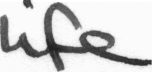

In [13]:
Image.open(file_path)

In [26]:
client, bucket = s3_init(bucketname='handwrittingdetection')

In [71]:
model_file = list(bucket.objects.filter(Prefix='models/language_model/model.param'))

In [78]:
model_file

[s3.ObjectSummary(bucket_name='handwrittingdetection', key='models/language_model/model.param'),
 s3.ObjectSummary(bucket_name='handwrittingdetection', key='models/language_model/model.param.config.json'),
 s3.ObjectSummary(bucket_name='handwrittingdetection', key='models/language_model/model.param.optim')]

# Inference 

In [1]:
import os
import time
import torch
from torch import optim
from models.context2vec.src.eval.mscc import mscc_evaluation
from models.context2vec.src.core.nets import Context2vec
from models.context2vec.src.util.args import parse_args
from models.context2vec.src.util.batch import Dataset
from models.context2vec.src.util.config import Config
from models.context2vec.src.util.io import write_embedding, write_config, read_config, load_vocab
device = 'cpu'
# args = parse_args()
modelfile = 'models/context2vec/models/model.param'
# modelfile = model_file[0].key
wordsfile = 'models/context2vec/models/embedding.vec'
config_file = modelfile+'.config.json'
config_dict = read_config(config_file)
model = Context2vec(vocab_size=config_dict['vocab_size'],
                    counter=[1]*config_dict['vocab_size'],
                    word_embed_size=config_dict['word_embed_size'],
                    hidden_size=config_dict['hidden_size'],
                    n_layers=config_dict['n_layers'],
                    bidirectional=config_dict['bidirectional'],
                    use_mlp=config_dict['use_mlp'],
                    dropout=config_dict['dropout'],
                    pad_index=config_dict['pad_index'],
                    device=device,
                    inference=True).to(device)
model.load_state_dict(torch.load(modelfile, map_location='cpu'))
optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'])
# optimizer.load_state_dict(torch.load(modelfile+'.optim'))
itos, stoi = load_vocab(wordsfile)
unk_token = config_dict['unk_token']
bos_token = config_dict['bos_token']
eos_token = config_dict['eos_token']

In [103]:
import os
import time
import torch
from torch import optim
from models.context2vec.src.eval.mscc import mscc_evaluation
from models.context2vec.src.core.nets import Context2vec
from models.context2vec.src.util.args import parse_args
from models.context2vec.src.util.batch import Dataset
from models.context2vec.src.util.config import Config
from models.context2vec.src.util.io import write_embedding, write_config, read_config, load_vocab

class Inference():
    def __init__(self, modelfile, wordsfile, config_file, device='cpu'):
        
        # args = parse_args()
        modelfile = 'models/context2vec/models/model.param'
        # modelfile = model_file[0].key
        wordsfile = 'models/context2vec/models/embedding.vec'
        config_file = modelfile+'.config.json'
        config_dict = read_config(config_file)
        model = Context2vec(vocab_size=config_dict['vocab_size'],
                            counter=[1]*config_dict['vocab_size'],
                            word_embed_size=config_dict['word_embed_size'],
                            hidden_size=config_dict['hidden_size'],
                            n_layers=config_dict['n_layers'],
                            bidirectional=config_dict['bidirectional'],
                            use_mlp=config_dict['use_mlp'],
                            dropout=config_dict['dropout'],
                            pad_index=config_dict['pad_index'],
                            device=device,
                            inference=True).to(device)
        model.load_state_dict(torch.load(modelfile, map_location='cpu'))
#         optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'])
        # optimizer.load_state_dict(torch.load(modelfile+'.optim'))
        itos, stoi = load_vocab(wordsfile)
        unk_token = config_dict['unk_token']
        bos_token = config_dict['bos_token']
        eos_token = config_dict['eos_token']
        
        
    def _return_split_sentence(self, sentence):
        if ' ' not in sentence:
            print('sentence should contain white space to split it into tokens')
            raise SyntaxError
        elif '[]' not in sentence:
            print('sentence should contain `[]` that notes the target')
            raise SyntaxError
        else:
            tokens = sentence.lower().strip().split()
            target_pos = tokens.index('[]')
            return tokens, target_pos
        
    def run_inference_by_user_input(self, sentence, model, itos, stoi, unk_token, bos_token, eos_token, device, topK=30):

        # evaluation mode 
        model.eval()
        # norm_weight
        model.norm_embedding_weight(model.criterion.W)

        tokens, target_pos = return_split_sentence(sentence)
        tokens[target_pos] = unk_token
        tokens = [bos_token] + tokens + [eos_token]
        indexed_sentence = [stoi[token] if token in stoi else stoi[unk_token] for token in tokens]
        input_tokens = \
            torch.tensor(indexed_sentence, dtype=torch.long, device=device).unsqueeze(0)
        topv, topi = model.run_inference(input_tokens, target=None, target_pos=target_pos, k=topK)
        output = []  
        for value, key in zip(topv, topi):
            output.append((value.item(), itos[key.item()]))
            print(value.item(), itos[key.item()])
        return output

In [2]:
def run_inference_by_user_input(sentence, 
                                model,
                                itos,
                                stoi,
                                unk_token,
                                bos_token,
                                eos_token,
                                device):

    def return_split_sentence(sentence):
        if ' ' not in sentence:
            print('sentence should contain white space to split it into tokens')
            raise SyntaxError
        elif '[]' not in sentence:
            print('sentence should contain `[]` that notes the target')
            raise SyntaxError
        else:
            tokens = sentence.lower().strip().split()
            target_pos = tokens.index('[]')
            return tokens, target_pos

    ''' 
    norm_weight
    '''
    # evaluation mode 
    model.eval()
    
    model.norm_embedding_weight(model.criterion.W)

    tokens, target_pos = return_split_sentence(sentence)
    tokens[target_pos] = unk_token
    tokens = [bos_token] + tokens + [eos_token]
    indexed_sentence = [stoi[token] if token in stoi else stoi[unk_token] for token in tokens]
    input_tokens = torch.tensor(indexed_sentence, dtype=torch.long, device=device).unsqueeze(0)
    topv, topi = model.run_inference(input_tokens, target=None, target_pos=target_pos)
    output = []  
    for value, key in zip(topv, topi):
        output.append((value.item(), itos[key.item()]))
        print(value.item(), itos[key.item()])
    return output

In [ ]:
modelfile = 'models/context2vec/models/model.param'
wordsfile = 'models/context2vec/models/embedding.vec'



In [3]:
left_text = 'the dog ran'
right_text = 'the house'

sentence = left_text + ' [] ' + right_text

run_inference_by_user_input(sentence, model, itos, stoi, unk_token=unk_token, 
                            bos_token=bos_token, eos_token=eos_token, device=device)


0.8051932454109192 into
0.5680792927742004 above
0.25667303800582886 through
0.0 <PAD>
0.0 <EOS>
0.0 <BOS>
-0.0033715590834617615 against
-0.02418931946158409 across
-0.09841619431972504 alongside
-0.25158366560935974 from


[(0.8051932454109192, 'into'),
 (0.5680792927742004, 'above'),
 (0.25667303800582886, 'through'),
 (0.0, '<PAD>'),
 (0.0, '<EOS>'),
 (0.0, '<BOS>'),
 (-0.0033715590834617615, 'against'),
 (-0.02418931946158409, 'across'),
 (-0.09841619431972504, 'alongside'),
 (-0.25158366560935974, 'from')]

In [83]:
!ls models/context2vec/models/

model.param             model.param.config.json


In [99]:
ls

__init__.py      run.py           templates/       tmp/
models/          static/          test_pipe.ipynb  utils.py


# LM MODEL

In [1]:
import os
import time
import torch
from torch import optim
from models.context2vec.src.eval.mscc import mscc_evaluation
from models.context2vec.src.core.nets import Context2vec
from models.context2vec.src.util.args import parse_args
from models.context2vec.src.util.batch import Dataset
from models.context2vec.src.util.config import Config
from models.context2vec.src.util.io import write_embedding, write_config, read_config, load_vocab
device = 'cpu'
# args = parse_args()
modelfile = 'models/context2vec/models/model.param'
# modelfile = model_file[0].key
wordsfile = 'models/context2vec/models/embedding.vec'
config_file = modelfile+'.config.json'
config_dict = read_config(config_file)
model = Context2vec(vocab_size=config_dict['vocab_size'],
                    counter=[1]*config_dict['vocab_size'],
                    word_embed_size=config_dict['word_embed_size'],
                    hidden_size=config_dict['hidden_size'],
                    n_layers=config_dict['n_layers'],
                    bidirectional=config_dict['bidirectional'],
                    use_mlp=config_dict['use_mlp'],
                    dropout=config_dict['dropout'],
                    pad_index=config_dict['pad_index'],
                    device=device,
                    inference=True).to(device)
model.load_state_dict(torch.load(modelfile, map_location='cpu'))
optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'])
# optimizer.load_state_dict(torch.load(modelfile+'.optim'))
itos, stoi = load_vocab(wordsfile)
unk_token = config_dict['unk_token']
bos_token = config_dict['bos_token']
eos_token = config_dict['eos_token']

In [2]:
def run_inference_by_user_input(sentence, 
                                model,
                                itos,
                                stoi,
                                unk_token,
                                bos_token,
                                eos_token,
                                device):

    def return_split_sentence(sentence):
        if ' ' not in sentence:
            print('sentence should contain white space to split it into tokens')
            raise SyntaxError
        elif '[]' not in sentence:
            print('sentence should contain `[]` that notes the target')
            raise SyntaxError
        else:
            tokens = sentence.lower().strip().split()
            target_pos = tokens.index('[]')
            return tokens, target_pos

    ''' 
    norm_weight
    '''
    # evaluation mode 
    model.eval()
    
    model.norm_embedding_weight(model.criterion.W)

    tokens, target_pos = return_split_sentence(sentence)
    tokens[target_pos] = unk_token
    tokens = [bos_token] + tokens + [eos_token]
    indexed_sentence = [stoi[token] if token in stoi else stoi[unk_token] for token in tokens]
    input_tokens = torch.tensor(indexed_sentence, dtype=torch.long, device=device).unsqueeze(0)
    topv, topi = model.run_inference(input_tokens, target=None, target_pos=target_pos)
    output = []  
    for value, key in zip(topv, topi):
        output.append((value.item(), itos[key.item()]))
        print(value.item(), itos[key.item()])
    return output

In [3]:
left_text = 'the dog ran'
right_text = 'the house'

sentence = left_text + ' [] ' + right_text

run_inference_by_user_input(sentence, model, itos, stoi, unk_token=unk_token, 
                            bos_token=bos_token, eos_token=eos_token, device=device)


0.8051932454109192 into
0.5680792927742004 above
0.25667303800582886 through
0.0 <PAD>
0.0 <EOS>
0.0 <BOS>
-0.0033715590834617615 against
-0.02418931946158409 across
-0.09841619431972504 alongside
-0.25158366560935974 from


[(0.8051932454109192, 'into'),
 (0.5680792927742004, 'above'),
 (0.25667303800582886, 'through'),
 (0.0, '<PAD>'),
 (0.0, '<EOS>'),
 (0.0, '<BOS>'),
 (-0.0033715590834617615, 'against'),
 (-0.02418931946158409, 'across'),
 (-0.09841619431972504, 'alongside'),
 (-0.25158366560935974, 'from')]

# OCR

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

ocr_model_path = 'models/ocr/models/ocr_5_len.h5'



def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# model = load_model(ocr_model_path, custom_objects={'ctc': ctc})
model = load_model(ocr_model_path, custom_objects={'<lambda>': lambda y_true, y_pred: y_pred})
model

/Users/mattevanoff/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/mattevanoff/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [5]:
model.predict()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [7]:
sess = tf.Session()
# K.set_session(sess)

In [9]:
K.set_session(sess)

In [10]:
img_width = 128
img_height = 64
img_path = '../../data/raw/word_level/c03/c03-096f/c03-096f-03-05.png'

from PIL import Image
import numpy as np
import cv2
import itertools

# sess = tf.Session()
# K.set_session(sess)

letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

img = cv2.imread(img_path)
# grayscale image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# resize image
img = cv2.resize(img, (img_width, img_height))
# change image type
img = img.astype(np.float32)
# scale image 
img /= 255
print(img.shape)
img = img.reshape((1, img_width, img_height, 1))

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

X_data = img
net_out_value = sess.run(net_out, feed_dict={net_inp: X_data})
print(net_out_value)
pred_texts = decode_batch(net_out_value)

pred_texts
# texts = []
# for label in labels:
#     text = ''.join(list(map(lambda x: letters[int(x)], label)))
#     texts.append(text)
    
texts

(64, 128)


FailedPreconditionError: Error while reading resource variable conv1/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/conv1/kernel)
	 [[node conv1/Conv2D/ReadVariableOp (defined at <ipython-input-4-2e47904da7de>:16)  = ReadVariableOp[dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv1/kernel)]]

Caused by op 'conv1/Conv2D/ReadVariableOp', defined at:
  File "/Users/mattevanoff/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-2e47904da7de>", line 16, in <module>
    model = load_model(ocr_model_path, custom_objects={'<lambda>': lambda y_true, y_pred: y_pred})
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/saving.py", line 230, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/saving.py", line 310, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/layers/serialization.py", line 64, in deserialize
    printable_module_name='layer')
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py", line 173, in deserialize_keras_object
    list(custom_objects.items())))
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py", line 1302, in from_config
    process_node(layer, node_data)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py", line 1260, in process_node
    layer(input_tensors[0], **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 510, in _apply_op_helper
    preferred_dtype=default_dtype)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1146, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1258, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1213, in _dense_var_to_tensor
    return self.value()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 644, in value
    return self._read_variable_op()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 727, in _read_variable_op
    self._dtype)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 508, in read_variable_op
    "ReadVariableOp", resource=resource, dtype=dtype, name=name)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Error while reading resource variable conv1/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/conv1/kernel)
	 [[node conv1/Conv2D/ReadVariableOp (defined at <ipython-input-4-2e47904da7de>:16)  = ReadVariableOp[dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv1/kernel)]]
